In [1]:
# 1. Get essential libraries
from vnstock import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

Observations:  1635


<Axes: xlabel='Time'>

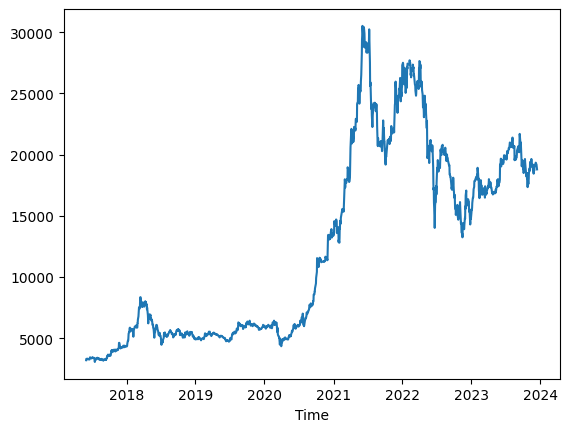

In [2]:
#2. Fetch data and visualize
# VIB
VIB = stock_historical_data(symbol = "VIB", start_date="2017-06-01", end_date="2023-12-15", resolution="1D", type = "stock", beautify=True, decor=True, source = "DNSE")
from matplotlib import pyplot
print("Observations: ",len(VIB['Close']))
VIB["Close"].plot()

In [3]:
# Preprocessing
df = pd.DataFrame(VIB['Close'])
df = df.dropna() 
df = df.reset_index(drop=True)
df

,Close
0,3210
1,3320
2,3290
3,3320
4,3340
...,...
1630,19200
1631,19200
1632,19050
1633,18900


In [4]:
# Check stationary
from statsmodels.tsa.stattools import adfuller
adf1 = adfuller(df['Close'], regression ='c', maxlag=30)
print("ADF stat: %f" % adf1[0])
print("p-value: %f" % adf1[1])
#Not stationary

ADF stat: -1.537267
p-value: 0.515002


In [5]:
adf2 = adfuller(df['Close'].diff().dropna(), regression ='c', maxlag=30)
print("ADF stat: %f" % adf2[0])
print("p-value: %f" % adf2[1])
#Stationary

ADF stat: -5.366501
p-value: 0.000004


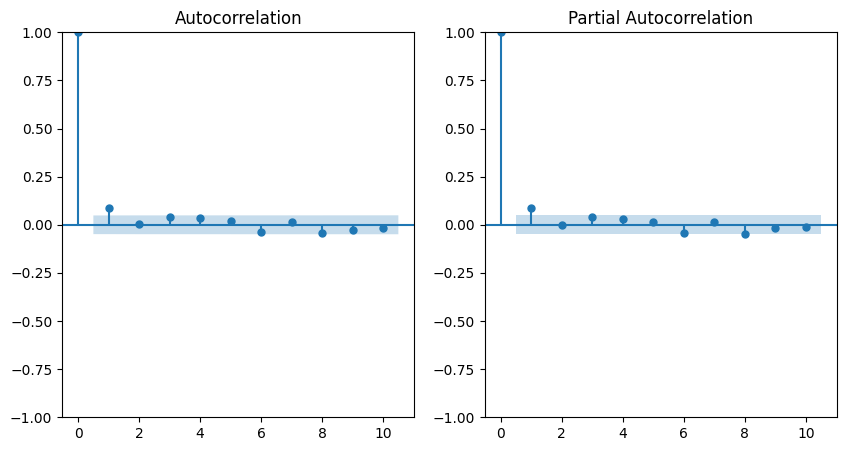

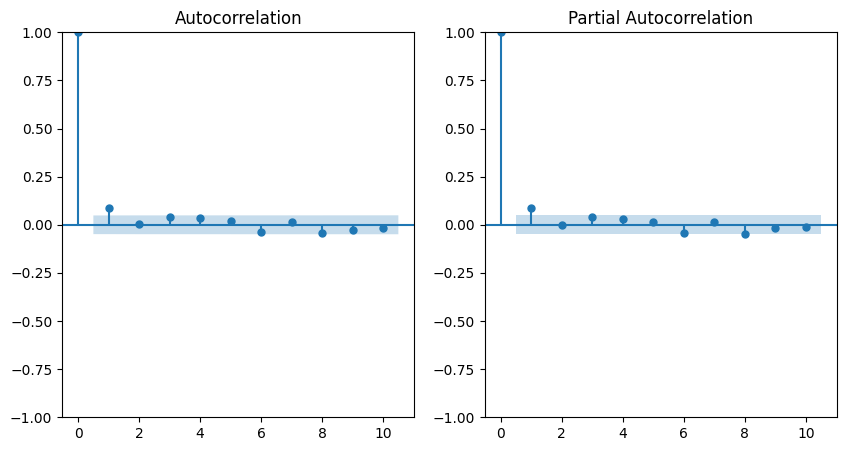

In [6]:
# Difference the data and plot the acf
fig, ax = plt.subplots(1,2,figsize=(10,5))
#ACF
sm.graphics.tsa.plot_acf(np.diff(df['Close']),lags=10, ax=ax[0])
# PACF
sm.graphics.tsa.plot_pacf(np.diff(df['Close']),lags=10, ax=ax[1])

In [7]:
# Test with ratio 7:3
train_size73 = int(0.7 * len(df))
test_size73 = int(0.3 * len(df))

train_data73 = df[:train_size73]
test_data73 = df[train_size73:]

In [8]:
# 4. Training process
# 7 : 3 RATIO
x_train73 = np.array(train_data73.index).reshape(-1, 1)
y_train73 = np.array(train_data73['Close'])

# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA

model73 = auto_arima(y_train73, trace=True, error_action='ignore', suppress_warnings=True)

# Fit the model
model_fit73 = model73.fit(y_train73)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=16153.466, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=16167.590, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=16152.393, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=16153.449, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=16170.918, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=16153.523, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=16153.400, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=16155.290, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=16154.568, Time=0.01 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 0.779 seconds


In [9]:
# 5. Testing process
# 7:3 RATIO
x_test73 = np.array(test_data73.index).reshape(-1, 1)
y_test73 = np.array(test_data73['Close'])
y_pred73 = model73.predict(n_periods=len(y_test73))

In [10]:
# 6. 60 days prediction
# 7:3 RATIO
last_index73 =  df.index[-1]
last_data73 =pd.RangeIndex(start=last_index73, stop=last_index73 + 60, step=1)

#create an array of 60 integers starting from last index
x_next_60_days73 = np.array(range(last_index73 + 1, last_index73 + 61)).reshape(-1, 1)

#predict the price for the next 60 days.
y_next_60_days73 = model73.predict(len(x_next_60_days73))

#print the prices for the next 60 days.
print('Predicted prices for the next 60 days: ')
print(y_next_60_days73)

Predicted prices for the next 60 days: 
[25561.5679332  25591.0821547  25611.77337407 25631.38421376
 25650.86276059 25670.3251081  25689.78547201 25709.24559302
 25728.70568428 25748.16577191 25767.62585909 25787.08594622
 25806.54603333 25826.00612045 25845.46620757 25864.92629469
 25884.3863818  25903.84646892 25923.30655604 25942.76664316
 25962.22673027 25981.68681739 26001.14690451 26020.60699163
 26040.06707874 26059.52716586 26078.98725298 26098.4473401
 26117.90742722 26137.36751433 26156.82760145 26176.28768857
 26195.74777569 26215.2078628  26234.66794992 26254.12803704
 26273.58812416 26293.04821127 26312.50829839 26331.96838551
 26351.42847263 26370.88855974 26390.34864686 26409.80873398
 26429.2688211  26448.72890821 26468.18899533 26487.64908245
 26507.10916957 26526.56925668 26546.0293438  26565.48943092
 26584.94951804 26604.40960515 26623.86969227 26643.32977939
 26662.78986651 26682.24995362 26701.71004074 26721.17012786]


In [11]:
# 7:3 RATIO
#RMSE
test_rmse = np.sqrt(np.mean((y_pred73 - y_test73)**2))
print('Testing RMSE:', test_rmse)

#MAPE
test_mape = np.mean(np.abs((y_test73 - y_pred73) / y_test73)) * 100
print('Testing MAPE:', test_mape)

#MAE
test_mae = np.mean(np.abs(y_pred73 - y_test73))
print('Testing MAE:', test_mae)

def MSLE (pred, actual):
    return np.mean((np.log(1+actual)-np.log(1+pred))*(np.log(1+actual)-np.log(1+pred)))
print("Testing MSLR: ", MSLE(y_pred73, y_test73))

Testing RMSE: 12038.005983568237
Testing MAPE: 61.08411464095309
Testing MAE: 10936.211335531845
Testing MSLR:  0.2533078885004433


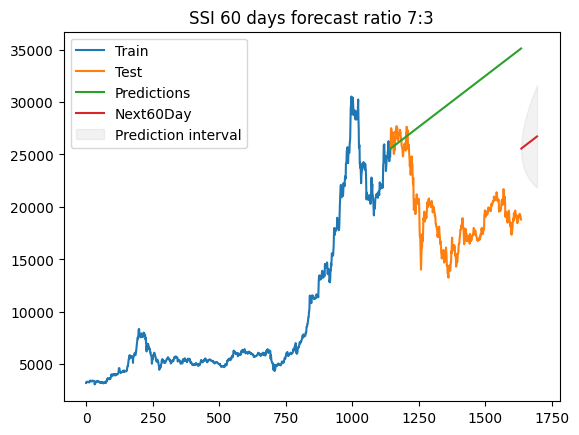

In [12]:
# 7:3 RATIO
# Forecast
n_periods = 60
fc, confint = model_fit73.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(df['Close']), len(df['Close'])+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(train_data73.index, train_data73['Close'])
plt.plot(test_data73.index, test_data73['Close'])
plt.plot(test_data73.index, y_pred73)

plt.plot(fc_series)
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.05)
plt.legend(['Train', 'Test', 'Predictions','Next60Day', 'Prediction interval'])

plt.title("SSI 60 days forecast ratio 7:3")
plt.show()